•	Proximity to transit (Percent of population within ¼ mile to frequent or high-capacity transit (e.g., Link Light Rail, Sounder Commuter Rail, Washington State ferries, bus rapid transit))

•	Proximity to current or future link light rail and streetcar. (Percent of area within ½ mile of 2030 high-capacity transit stops/stations)


In [1]:
import os, sys, time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
pd.options.mode.chained_assignment = None
import h5py
import sqlalchemy
from shapely import wkt
import geopandas as gpd
import seaborn as sns
from itertools import cycle, islice
import pyodbc
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
sys.path.append(os.path.join(os.getcwd(),r'..\..\..'))
from input_configuration import base_year

%matplotlib inline

from IPython.display import display, HTML

if (sys.version_info < (3, 0)):
    HTML('''<script>
    code_show=true; 
    function code_toggle(/) {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

# Relative path between notebooks and goruped output directories
relative_path = '../../../outputs'
survey_path = '../../../inputs/base_year/survey'

pd.options.display.float_format = '{:0,.0f}'.format

In [3]:
# List of Stations
# Load transit stops file

#"The definition we have been using for the RTP is BRT, LRT, Commuter Rail, StreetCar and Ferry."
df = pd.read_csv(r'../../../inputs/scenario/networks/transit_stops.csv')
# Streetcar is coded as light rail
df['hct'] = 0
df.loc[df[['commuter_rail','light_rail','ferry','brt']].sum(axis=1) > 0,'hct'] = 1
df_hct = df[df['hct'] == 1]

# Map of Stations
# Load as a geodataframe
gdf_hct = gpd.GeoDataFrame(
    df_hct, geometry=gpd.points_from_xy(df_hct.x, df_hct.y))

crs = {'init' : 'EPSG:2285'}
gdf_hct.crs = crs

distance = 5280.0/4

In [4]:
dirname = r'..\..\..\outputs\RTP\displacement'
if not os.path.exists(dirname):
            os.makedirs(dirname)

# HCT Station Location

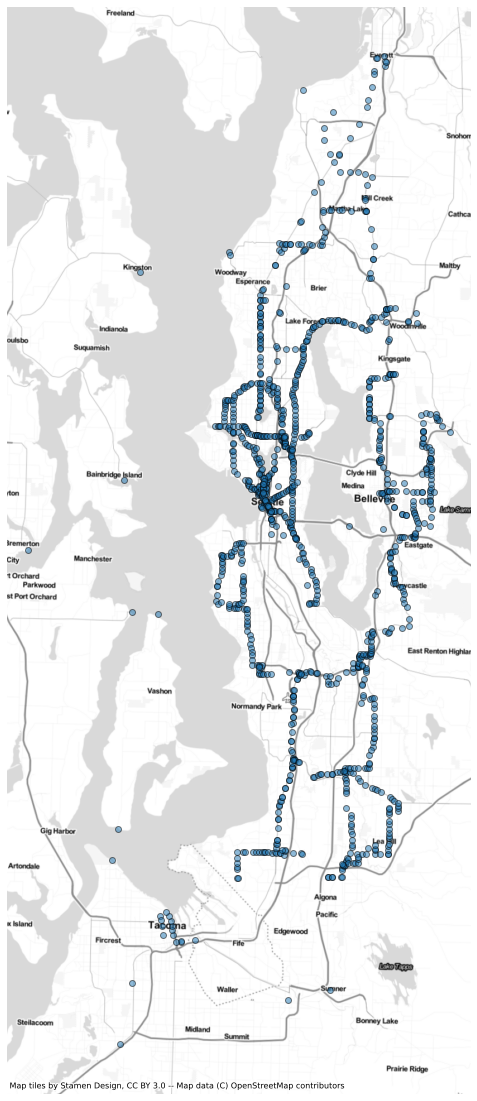

In [5]:
import contextily as ctx
ax = gdf_hct.plot(figsize=(20,20), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite, crs=crs)
ax.set_axis_off()

# Households Living Near HCT Stations

In [6]:
df_lu = pd.read_csv(r'..\..\..\inputs\scenario\landuse\parcels_urbansim.txt',
                   delim_whitespace=True)

# Load as a geodataframe
gdf_lu = gpd.GeoDataFrame(
    df_lu, geometry=gpd.points_from_xy(df_lu.XCOORD_P, df_lu.YCOORD_P))

crs = {'init' : 'EPSG:2285'}
gdf_lu.crs = crs

parcel_geog = pd.read_sql_table('parcel_'+base_year+'_geography', 'sqlite:///../../../inputs/db/soundcast_inputs.db')

In [7]:
df_lu = df_lu.merge(parcel_geog,left_on='PARCELID', right_on='ParcelID')

In [8]:
def calculate_buffer(gdf_lu, gdf_network, distance):
    
    # Buffer the HCT station gdf
    gdf_network['geometry'] = gdf_network.buffer(distance)

    gdf_intersect = gpd.overlay(gdf_network, gdf_lu, how="intersection", keep_geom_type=False)
    df = df_lu[df_lu['PARCELID'].isin(gdf_intersect['PARCELID'].unique())]

#     df = df.merge(parcel_geog,left_on='PARCELID', right_on='ParcelID')
    
    return df

In [9]:
def aggregate_parcels(df, col_dict, sum_field):
    results_df = pd.DataFrame()
    for col, name in col_dict.items():
        _df = df.groupby(col).sum()[[sum_field]]
        _df['group'] = name
        results_df = results_df.append(_df)
    results_df = results_df.reset_index()
    
    return results_df

In [10]:
df_025 = calculate_buffer(gdf_lu, gdf_hct, distance=5280.0/4)

In [11]:
# df_025

In [12]:
pd.options.display.float_format = '{:0,.0f}'.format
col_dict = {'Census2010Tract': 'Tract'}

df = aggregate_parcels(df_025, col_dict, 'HH_P')
df.rename(columns={'HH_P': 'HH_quarter_mile'}, inplace=True)

In [13]:
_df = df.merge(df_lu.groupby('Census2010Tract').sum()[['HH_P']].reset_index(),left_on='Census2010Tract', right_on='Census2010Tract')


In [14]:
def read_from_sde(connection_string, feature_class_name, version,
                  crs={'init': 'epsg:2285'}, is_table = False):
    """
    Returns the specified feature class as a geodataframe from ElmerGeo.
    
    Parameters
    ----------
    connection_string : SQL connection string that is read by geopandas 
                        read_sql function
    
    feature_class_name: the name of the featureclass in PSRC's ElmerGeo 
                        Geodatabase
    
    cs: cordinate system
    """


    engine = sqlalchemy.create_engine(connection_string)
    con=engine.connect()
    #con.execute("sde.set_current_version {0}".format(version))
    if is_table:
        gdf=pd.read_sql('select * from %s' % 
                   (feature_class_name), con=con)
        con.close()

    else:
        df=pd.read_sql('select *, Shape.STAsText() as geometry from %s' % 
                   (feature_class_name), con=con)
        con.close()

        df['geometry'] = df['geometry'].apply(wkt.loads)
        gdf=gpd.GeoDataFrame(df, geometry='geometry')
        gdf.crs = crs
        cols = [col for col in gdf.columns if col not in 
                ['Shape', 'GDB_GEOMATTR_DATA', 'SDE_STATE_ID']]
        gdf = gdf[cols]
    
    return gdf


In [15]:
# Load  tract geographies from ElmerGeo
connection_string = 'mssql+pyodbc://AWS-PROD-SQL\Sockeye/ElmerGeo?driver=SQL Server?Trusted_Connection=yes'
crs = {'init' : 'EPSG:2285'}
version = "'DBO.Default'"
gdf_shp = read_from_sde(connection_string, 'tract2010', version, crs=crs, is_table=False)


In [16]:
# _df['Census2010Tract'] = _df['Census2010Tract'].astype('int').astype('str')
_df['Census2010Tract']  = _df['Census2010Tract'].astype('str').apply(lambda x: x.split('.')[0])
merged_df = gdf_shp.merge(_df, left_on='geoid10', right_on='Census2010Tract', how='left')

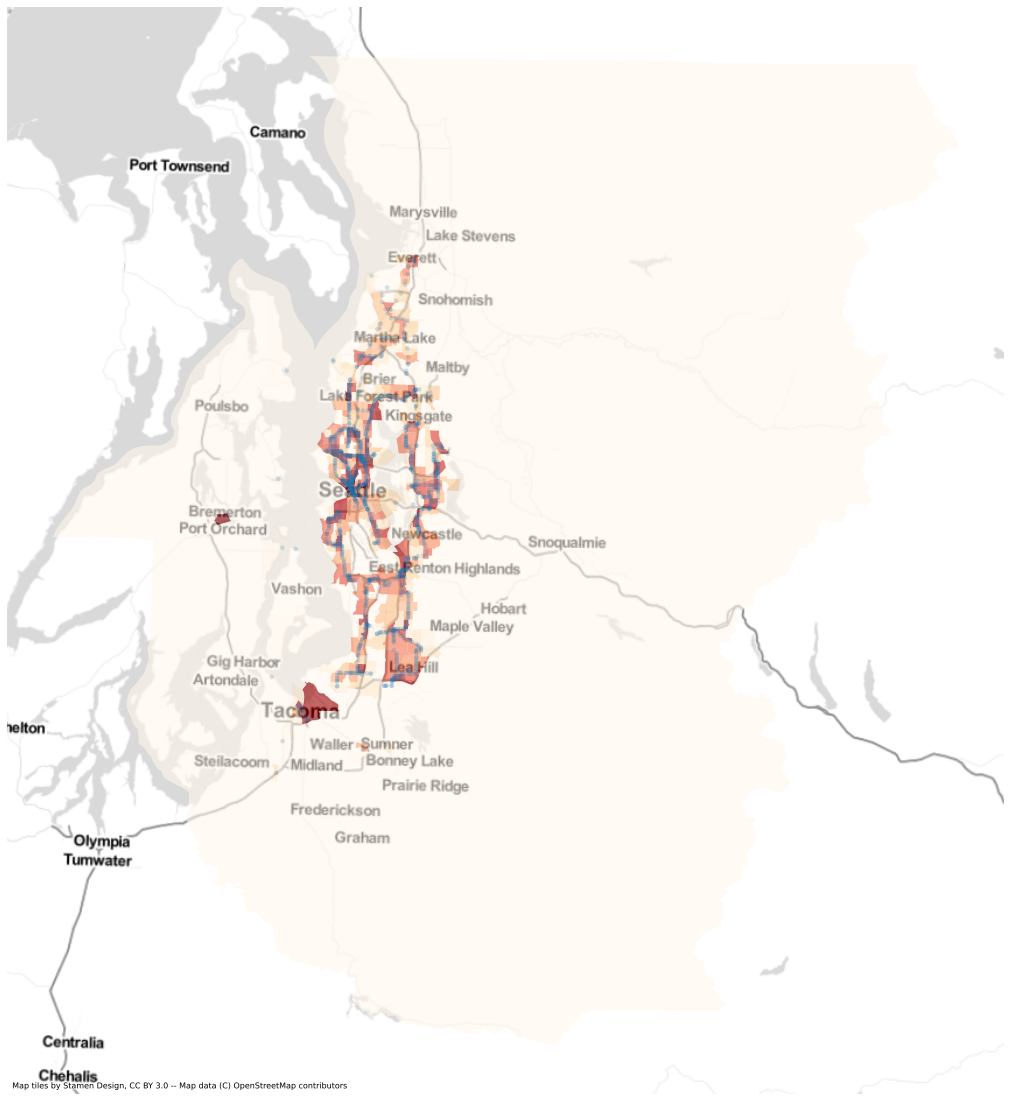

In [17]:
merged_df['percent_HH_quarter_mile'] = merged_df['HH_quarter_mile']/merged_df['HH_P']
merged_df['percent_HH_quarter_mile'] = merged_df['percent_HH_quarter_mile'].fillna(0)
f, ax = plt.subplots(figsize=(20,20))

merged_df[['geoid10','tractce10','HH_P','HH_quarter_mile','percent_HH_quarter_mile']].to_csv(r'..\..\..\outputs\RTP\displacement\hct_hh_coverage.csv',
                                                                                            index=False)

ax = merged_df.plot(ax=ax, column='percent_HH_quarter_mile', figsize=(20,20), cmap='OrRd', alpha=0.6)
ax = gdf_hct.plot(ax=ax, alpha=0.2)
# merged_df
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite, crs=crs)
ax.set_axis_off()



# Percent of Land Area
Percent of tract land area within 1/2 miles of HCT stations. This excludes water area.  

In [26]:
distance = 5280/2

# List of Stations
# Load transit stops file

#"The definition we have been using for the RTP is BRT, LRT, Commuter Rail, StreetCar and Ferry."
df = pd.read_csv(r'../../../inputs/scenario/networks/transit_stops.csv')
# Streetcar is coded as light rail
df['hct'] = 0
df.loc[df[['commuter_rail','light_rail','ferry','brt']].sum(axis=1) > 0,'hct'] = 1
df_hct = df[df['hct'] == 1]

# Map of Stations
# Load as a geodataframe
gdf_hct = gpd.GeoDataFrame(
    df_hct, geometry=gpd.points_from_xy(df_hct.x, df_hct.y))

crs = {'init' : 'EPSG:2285'}
gdf_hct.crs = crs

gdf_shp = read_from_sde(connection_string, 'tract2010_nowater', version, crs=crs, is_table=False)


In [27]:
gdf_hct['geometry'] = gdf_hct.buffer(distance)


In [28]:
area_gdf = gpd.overlay(gdf_shp, gdf_hct, "intersection")

In [29]:
# area_gdf.plot(figsize=(20,20))

In [30]:
area_gdf = area_gdf.dissolve('geoid10')
area_gdf['quarter_mile_hct_sq_ft'] = area_gdf['geometry'].area

In [31]:
gdf_shp['total_area'] = gdf_shp['geometry'].area
newdf = gdf_shp[['geoid10','total_area','geometry']].merge(area_gdf, left_on='geoid10', right_index=True)

In [32]:
newdf['percent_hct'] = newdf['quarter_mile_hct_sq_ft']/newdf['total_area']

In [33]:
newdf[['geoid10','quarter_mile_hct_sq_ft','total_area','percent_hct']].to_csv(r'..\..\..\outputs\RTP\displacement\hct_area_coverage.csv',
                                                                             index=False)